# Sarsa

## Libraries


In [5]:
import numpy as np
import gym
import time
from tqdm import tqdm
import metrics_m as mm
from IPython.display import clear_output
import optuna

## Core algorithm
### Sarsa algorithm
Sarsa means state-action-reward-state-action. Therefore unlike strict Q-Learning, there is a policy to follow. 
Actually, Sarsa is a type of Q-learning algorithm. It is a combination of Q-learning and Reinforcement learning.
The algorithm starts with a random policy, and then it updates the policy based on the reward it receives. This creates a tupple of (State,Action). Once an action is executed there is a new state (s') and reward(r). This creates a new tuple of (State, Action, Reward, State'). NB the quote for the second state. New state (s') and reward (r) are evaluated so a new action (a') is taken. Finally another tuple of (State, Action, Reward, State', Action') NB quote for new State and Action
{{equation here}}
The Q-Value is defined using the the state (s') and the new action (a'). This is different to the Q-Learning algorithm. Indeed strict Q-Learning would only use the maximum of Q(s',a)

### Q-Table
It is a table that stores the Q-value for each action.
The Q-Table will be updated by the Sarsa algorithm it behaves like a recursive function.

### Hyperparameters
- Alpha: learning rate: how much the agent will learn from the experience, how much the Q table would be updated
- Gamma: discount factor: how much the agent will consider future rewards, how much confidence would be given to the future rewards
- Initial conditions (Q(s0,a0)): the first time an action is taken the reward is used to set the value of Q. This allows immediate learning in case of fixed deterministic rewards.

#### Q-Table update process
While Q-learning will watch which action to select on s2 that will bring the largest reward (but the action estimate at this step in s2 may not bring the largest reward next), Sarsa take the action estimated at the s2 step and take it as the action to be done next.
So the actual calculated value of Q(s1, a2), we will slightly change it, remove maxQ, and replace it with It is the Q value of a2 that we actually selected on s2. Finally, like Q learning, find the gap between reality and estimate and update Q(s1, a2) in the Q table.

In [6]:
def fit(alpha, epsilon,gamma,total_episodes, max_steps):
    # Defining utility functions to be used n the learning process
    # Function to choose the next action
    def choose_action(state):
        action = 0
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
        return action

    # Function to learn the Q-value
    def update(state, state2, reward, action, action2):
        predict = Q[state, action]
        target = reward + gamma * Q[state2, action2]
        Q[state, action] = Q[state, action] + alpha * (target - predict)

    # Initializing the Q-matrix
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    # Training the learning agent
    # Initializing the reward
    reward = 0
    # Initializing metrics array
    all_games_rewards = []
    all_games_steps_counts = []
    all_games_times = []

    # Starting the SARSA learning
    for episode in tqdm(range(total_episodes)):
        t0 = time.time()
        steps_count, reward1 = 0, 0
        rewards = []
        t = 0
        state1 = env.reset()
        action1 = choose_action(state1)

        while t < max_steps:
            # Visualizing the training
            # env.render()

            # Getting the next state
            state2, reward, done, info = env.step(action1)

            # Choosing the next action
            action2 = choose_action(state2)

            # Learning the Q-value
            update(state1, state2, reward, action1, action2)

            state1 = state2
            action1 = action2

            # Updating the respective vaLues
            t += 1
            reward += 1

            # If at the end of learning process
            next_state, reward, done, info = env.step(action1)
            if done:
                break

            # Update metrics
            rewards.append(reward1)
            steps_count += 1

        # Add updated metrics to array
        all_games_rewards.append(np.mean(rewards))
        all_games_steps_counts.append(steps_count)
        all_games_times.append(time.time()-t0)

    # Return the dicts containing the metrics updated
    return_dict = {}
    return_dict["rewards"] = all_games_rewards
    return_dict["steps"] = all_games_steps_counts
    return_dict["games_times"] = all_games_times
    return_dict["Q_table"] = Q

    return(return_dict)
    

## Optimization
Overall, optimizing a ML model is about trying different values for it's hyperparameter to find the one that gives the best results.
Here we want we have 4 parameters that we will want to use for that :
* Alpha = between 0 and 1
* Epsilon = between 0 and 1
* Gamma = between 0 and 1
* Number of games = between 10000 and 30000 unless the optimization takes too long

To make this optimization step automatic, we use `optuna` which is a python library that already implement this behaviour.

In [7]:

def objective(trial):
    results = fit(trial.suggest_float("alpha", 0, 1 ), 
        trial.suggest_float("epsilon", 0, 1 ), 
        trial.suggest_float("gamma", 0, 1 ), 
        trial.suggest_int("nb_games", 10000, 30000 ), 
        trial.suggest_int("max_steps",50, 150)
    )

    return min(results["steps"])

# Environment
env = gym.make("Taxi-v3").env
env.reset()
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

[I 2022-06-16 14:32:15,534] A new study created in memory with name: no-name-5240a18d-af5c-4efb-ad9c-7199ae7996cb
100%|██████████| 11733/11733 [01:03<00:00, 184.64it/s]
[I 2022-06-16 14:33:19,090] Trial 0 finished with value: 4.0 and parameters: {'alpha': 0.46908465057211257, 'epsilon': 0.4725454739824205, 'gamma': 0.3085916272210417, 'nb_games': 11733, 'max_steps': 87}. Best is trial 0 with value: 4.0.
100%|██████████| 19279/19279 [01:08<00:00, 282.71it/s]
[I 2022-06-16 14:34:27,292] Trial 1 finished with value: 5.0 and parameters: {'alpha': 0.8311581701399939, 'epsilon': 0.9833054850575422, 'gamma': 0.243994337360103, 'nb_games': 19279, 'max_steps': 54}. Best is trial 0 with value: 4.0.
100%|██████████| 29134/29134 [01:51<00:00, 262.27it/s]
[I 2022-06-16 14:36:18,406] Trial 2 finished with value: 3.0 and parameters: {'alpha': 0.8834733949862268, 'epsilon': 0.8977958346954058, 'gamma': 0.985447401115688, 'nb_games': 29134, 'max_steps': 68}. Best is trial 2 with value: 3.0.
100%|██████

## Training

In [8]:
# Environment
env = gym.make("Taxi-v3")
alpha = study.best_params["alpha"]
epsilon = study.best_params["epsilon"]
gamma = study.best_params["gamma"]
nb_games = study.best_params["nb_games"]
max_steps = study.best_params["max_steps"]

results = fit(alpha, epsilon, gamma, nb_games, max_steps)


100%|██████████| 25898/25898 [02:07<00:00, 203.35it/s]


## Metrics

### Steps

#### Graph

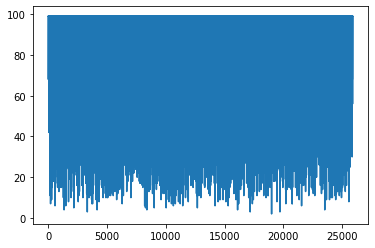

{'q1': 99.0, 'median': 99.0, 'q3': 99.0, 'max': 99, 'min': 2}

In [9]:
mm.statMetrics(results["steps"], plot=True)

#### Better and worst

In [10]:
mm.minmaxMetrics(results["steps"])

{'min': 2, 'min_game': 18999, 'max': 99, 'max_game': 0}

### Rewards

#### Graph

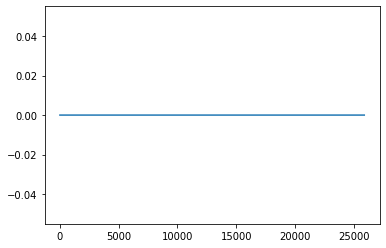

{'q1': 0.0, 'median': 0.0, 'q3': 0.0, 'max': 0.0, 'min': 0.0}

In [11]:
mm.statMetrics(results["rewards"], plot=True)

### Better and worst

In [12]:
mm.minmaxMetrics(results["rewards"])

{'min': 0.0, 'min_game': 0, 'max': 0.0, 'max_game': 0}

In [14]:
# print(f"Overall games min reward : { results['min_reward'] } ")
# print(f"Overall games max reward : { results['max_reward'] }")

### Runtime

#### Graph

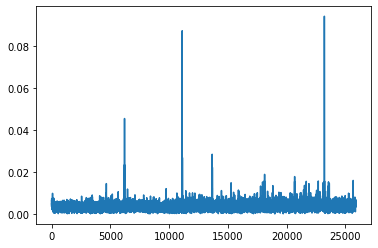

{'q1': 0.004548251628875732,
 'median': 0.004940032958984375,
 'q3': 0.0054048895835876465,
 'max': 0.09409499168395996,
 'min': 0.0002162456512451172}

In [15]:
mm.statMetrics(results["games_times"], plot=True)

#### Better and worst

In [16]:
mm.minmaxMetrics(results["games_times"])

{'min': 0.0002162456512451172,
 'min_game': 18999,
 'max': 0.09409499168395996,
 'max_game': 23214}

### Win/Lose Rates
This algorithm has no need to have any win/lose rates because on the training it doesn't have any timeout (about steps max) nor stops at any fails so basically the winrate will be 100% anyway so it's a irrelevant metrics for this one

The output is the better of the X trials we tried.


## Test

In [17]:
# Environment
env = gym.make("Taxi-v3").env
env.reset()

# Useful variables
steps = 0
done = None
history = []

# Run the game !
while not done:
    env.render()
    time.sleep(1.5)
    steps += 1
    state = env.s
    action = np.argmax(results["Q_table"][state]) 
    next_state, reward, done, info = env.step(action) 
    clear_output()

print(f"This game was resolved in { steps } steps")


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


KeyboardInterrupt: 